In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966 (90 deg)
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0 (0 deg)
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793 (180 deg)
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def vector_reject(u,v):
    #project u on v, subtract u1 from u
    P = np.outer(v,(v.T))/(v@(v.T))
    u_sub = u - P@u
#     another calculation, to double-check
#     v_norm = np.sqrt(sum(v**2))    
#     proj_u_on_v = (np.dot(u, v)/v_norm**2)*v
#     u_sub = u - proj_u_on_v
    return u_sub

# Single Lag

In [2]:
dataset_5ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [3]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

171 trials
65 neurons
(444690, 65)
(444493, 65)
(444690, 20)
PCA total var explained: 0.47329835482101773


In [7]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only 0 will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [5]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    # stored by trials for train/test splitting
    rates_array = nans([n_trials,n_timepoints,n_neurons])
    vel_array = nans([n_trials,n_timepoints,2])
    i=0
    for idx, trial in rates_df.groupby('trial_id'):
        rates_array[i,:,:]=trial[x_field].to_numpy()
        i+=1    
    i=0
    for idx, trial in vel_df.groupby('trial_id'):
        vel_array[i,:,:]=trial[y_field].to_numpy()
        i+=1  
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    rates_array_reshaped = rates_array.reshape((rates_array.shape[0]*rates_array.shape[1]),rates_array.shape[2])
    vel_array_reshaped = vel_array.reshape((vel_array.shape[0]*vel_array.shape[1]),vel_array.shape[2])
    lr_all.fit(rates_array_reshaped, vel_array_reshaped)
    
    kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,n_trials)):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

In [6]:
def get_R2_reject(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, sub_weights):
    
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    # stored by trials for train/test splitting
    rates_array = nans([n_trials,n_timepoints,n_neurons])
    vel_array = nans([n_trials,n_timepoints,2])
    i=0
    for idx, trial in rates_df.groupby('trial_id'):
        rates_array[i,:,:]=trial[x_field].to_numpy()
        i+=1    
    i=0
    for idx, trial in vel_df.groupby('trial_id'):
        vel_array[i,:,:]=trial[y_field].to_numpy()
        i+=1  
    
    rates_array_reshaped = rates_array.reshape((rates_array.shape[0]*rates_array.shape[1]),rates_array.shape[2])
    vel_array_reshaped = vel_array.reshape((vel_array.shape[0]*vel_array.shape[1]),vel_array.shape[2])
    
    true_concat = vel_array_reshaped
    pred_concat = nans([n_trials*n_timepoints,2])
    
    weight_x = sub_weights[0,:]
    weight_y = sub_weights[1,:]
    pred_concat[:,0] = np.dot(rates_array_reshaped,weight_x)
    pred_concat[:,1] = np.dot(rates_array_reshaped,weight_y)
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2

## with Neurons

In [7]:
lag_axis = np.arange(-300,300,20)
x_field = 'spikes_smth_40'
y_field ='hand_vel'
trial_mask = passive_mask

R2: 0.11417327678311895
R2: 0.13612833707198468
R2: 0.15259044862728688
R2: 0.16360118937399326
R2: 0.17145479599213875
R2: 0.17973882533526508
R2: 0.1924622494510353
R2: 0.21439499699186892
R2: 0.25148384171809324
R2: 0.30894141600240377
R2: 0.3871877891991541
R2: 0.4785416014278434
R2: 0.5684401742147114
R2: 0.6406455129289887
R2: 0.6838761183201709
R2: 0.6970304837715837
R2: 0.6886040972887635
R2: 0.6698343089481315
R2: 0.6476278795691104
R2: 0.6226410564055581
R2: 0.5918849707089604
R2: 0.5526405293826756
R2: 0.5059227222090734
R2: 0.4569515471895721
R2: 0.4130337488269701
R2: 0.38028949700850134
R2: 0.3587163310665681
R2: 0.3426685383960799
R2: 0.3264877320200549
R2: 0.30843154604083367


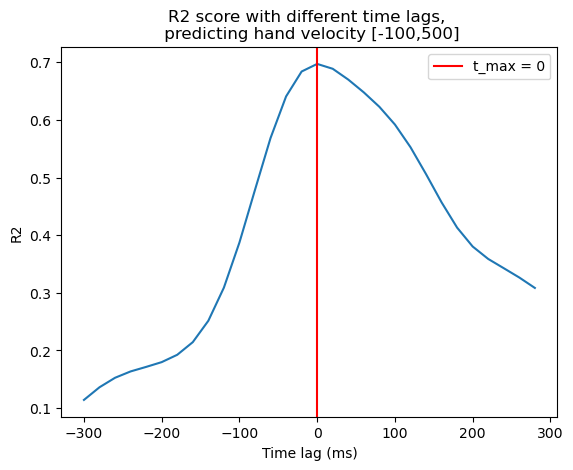

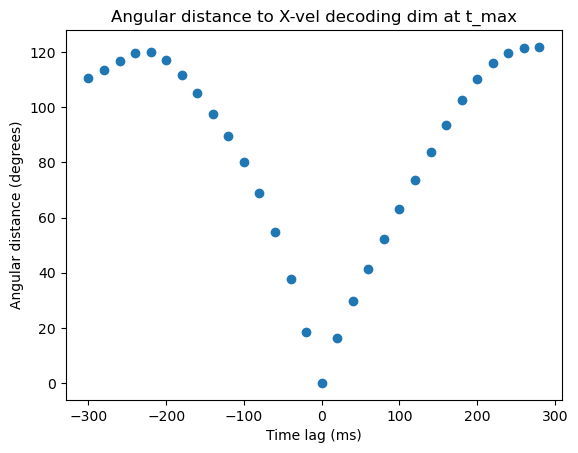

R2: 0.1702952509346065
R2: 0.17938025847935424
R2: 0.1813683251017043
R2: 0.17939313814838387
R2: 0.1810368049809734
R2: 0.19418771827463388
R2: 0.2223115867328741
R2: 0.2623067455475404
R2: 0.3048777771623228
R2: 0.3388201202587581
R2: 0.3561027149092433
R2: 0.349344779437997
R2: 0.3077390021203966
R2: 0.2235805096189044
R2: 0.10825247938126437
R2: -3.056161697889692e-05
R2: -0.0530154855494096
R2: -0.020516888956388035
R2: 0.09170163528294684
R2: 0.2432357187885117
R2: 0.37817913056965957
R2: 0.45051842220972627
R2: 0.4433885781238731
R2: 0.37548539318685137
R2: 0.2837041176052334
R2: 0.19635401669670383
R2: 0.12522764224401695
R2: 0.07632042947903583
R2: 0.05266937426798368
R2: 0.05435545737666625


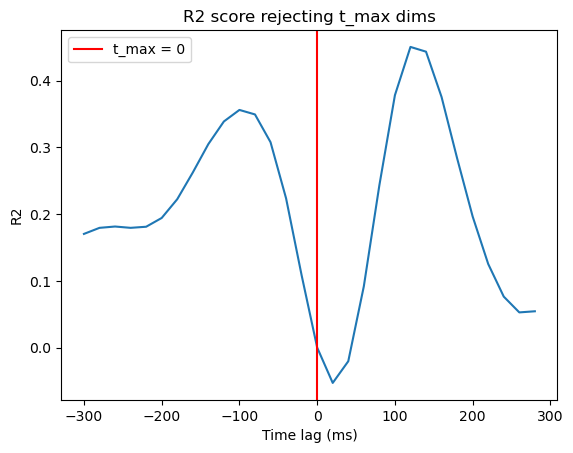

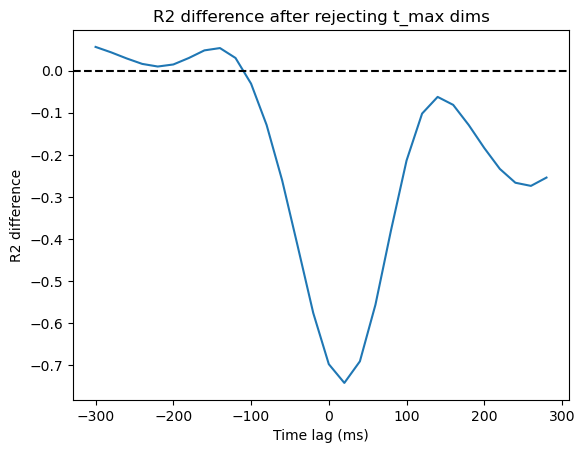

In [8]:
whole_r2_array = []
whole_coef_array = []
for lag in lag_axis:
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    whole_r2_array.append(r2)
    whole_coef_array.append(coef)

curr_r2_array = np.array(whole_r2_array)
curr_coef_array = np.array(whole_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.3833898828386244
R2: -0.33613118958184374
R2: -0.30649948003955685
R2: -0.33092917518425
R2: -0.37777092502925247
R2: -0.41192725025518384
R2: -0.4559675162276384
R2: -0.46100050880171883
R2: -0.3560434662587717
R2: -0.1494349143581073
R2: 0.1151884476636229
R2: 0.34405020920757934
R2: 0.5262141629538875
R2: 0.6521879250833247
R2: 0.7209534277759491
R2: 0.7406676805624309
R2: 0.7411929221737377
R2: 0.7494433754756084
R2: 0.7597525484282291
R2: 0.6799288120218321
R2: 0.7429922555356874
R2: 0.7391493733419126
R2: 0.7203936214315023
R2: 0.7147706281850628
R2: 0.7200150524814628
R2: 0.7076480339386244
R2: 0.688516530054936
R2: 0.6618053290431192
R2: 0.6237392097793898
R2: 0.5921960411272709


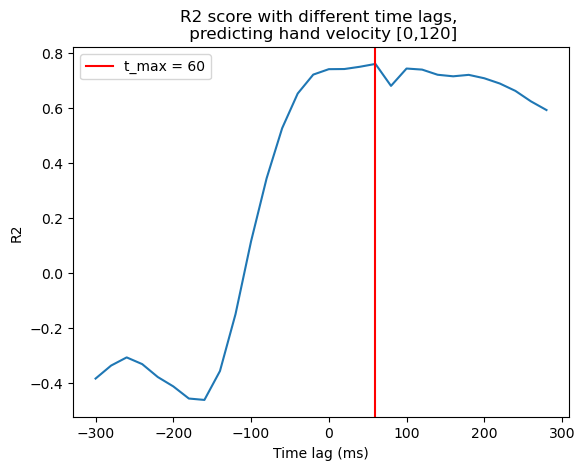

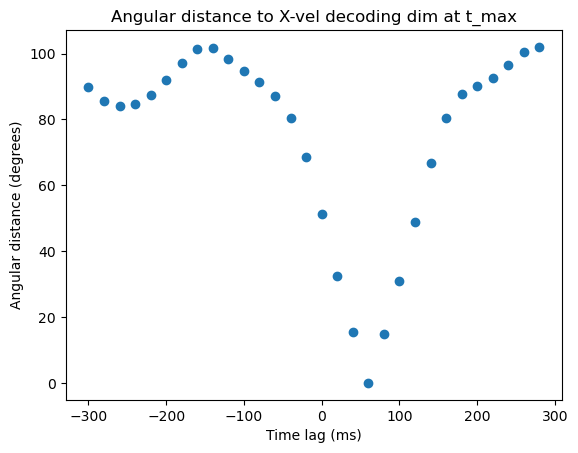

R2: 0.15993343578218566
R2: 0.139253904172005
R2: 0.07791555068319467
R2: 0.011957050798361624
R2: -0.03062978821968043
R2: -0.04747683577549844
R2: -0.057350097740398676
R2: -0.053510833162683014
R2: 0.0666269654954239
R2: 0.28972911652993927
R2: 0.4563858936146168
R2: 0.5702757969200007
R2: 0.6592648678753061
R2: 0.7252831783392788
R2: 0.7467566989188066
R2: 0.6837654559977544
R2: 0.4962999923302508
R2: 0.22000907936596636
R2: -0.003542451611662223
R2: -0.03933403867546126
R2: 0.13412158498995652
R2: 0.4079527419985892
R2: 0.6275934230415883
R2: 0.7149502654897715
R2: 0.7097751995637966
R2: 0.6994024823990105
R2: 0.6941437382017313
R2: 0.6537590949878402
R2: 0.5588328073599393
R2: 0.4510868473654699


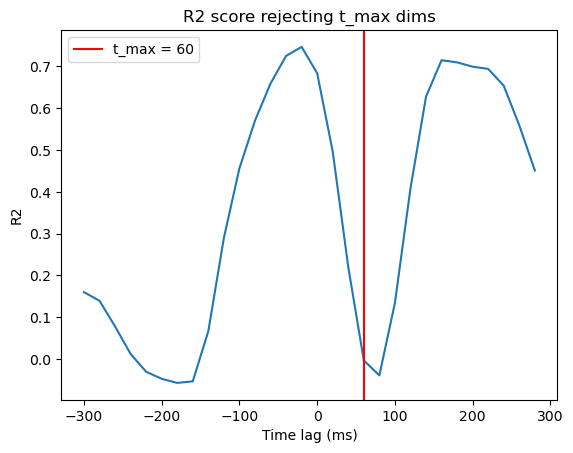

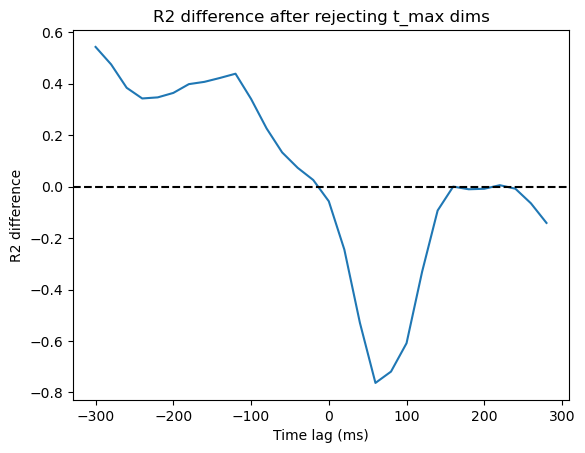

In [9]:
early_r2_array = []
early_coef_array = []
for lag in lag_axis:
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    early_r2_array.append(r2)
    early_coef_array.append(coef)

curr_r2_array = np.array(early_r2_array)
curr_coef_array = np.array(early_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



## with PCA

In [12]:
x_field = 'PCA'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)

R2: 0.14320998622063819
R2: 0.1632075362094466
R2: 0.17991340114646337
R2: 0.19280622283241833
R2: 0.20208462047017373
R2: 0.20901774167622578
R2: 0.21637541140996008
R2: 0.22933486510911383
R2: 0.25555820201880175
R2: 0.30232411959257466
R2: 0.37157112476545084
R2: 0.4567928787284601
R2: 0.5435445495126303
R2: 0.6134121352869825
R2: 0.6515487476934986
R2: 0.6544934691720063
R2: 0.6320419821350456
R2: 0.5996120152436689
R2: 0.5672106565145116
R2: 0.5353088309670242
R2: 0.4989803793840234
R2: 0.45435032056594526
R2: 0.4026585919941257
R2: 0.35015866129166884
R2: 0.3047743217627321
R2: 0.27228555871899496
R2: 0.25413873260934505
R2: 0.2476026071303833
R2: 0.24695618178320877
R2: 0.24601390184295158


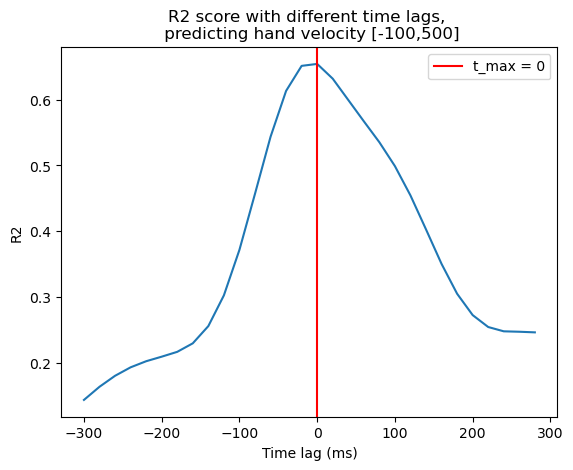

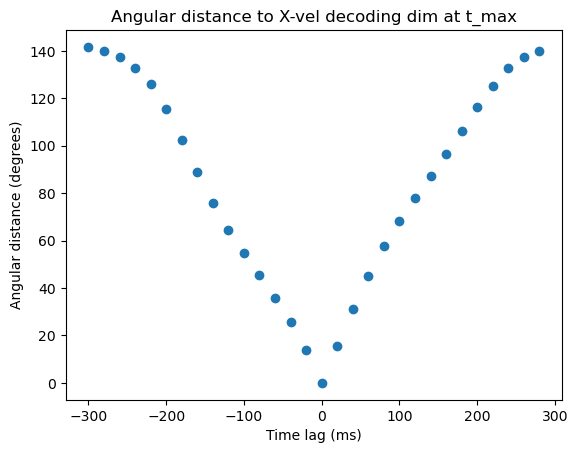

R2: 0.06872510012750621
R2: 0.08900211017845872
R2: 0.11241948983602457
R2: 0.13878644045349753
R2: 0.16756796517054973
R2: 0.19723319890774982
R2: 0.22497693523595574
R2: 0.2466354204885145
R2: 0.2567788478075702
R2: 0.24957349278808216
R2: 0.22068328442697915
R2: 0.16985192446414732
R2: 0.10400279385847555
R2: 0.03916894472922272
R2: -0.002294695122363688
R2: -3.056161697889692e-05
R2: 0.05405609379512544
R2: 0.1500414460418792
R2: 0.2632581912715446
R2: 0.36439865961524665
R2: 0.4295868480152065
R2: 0.44622538859746763
R2: 0.41584438558787995
R2: 0.35269200190489924
R2: 0.27613884871613836
R2: 0.20280011045442625
R2: 0.1438179187815093
R2: 0.1043300697776044
R2: 0.08393761954822798
R2: 0.07946278756521408


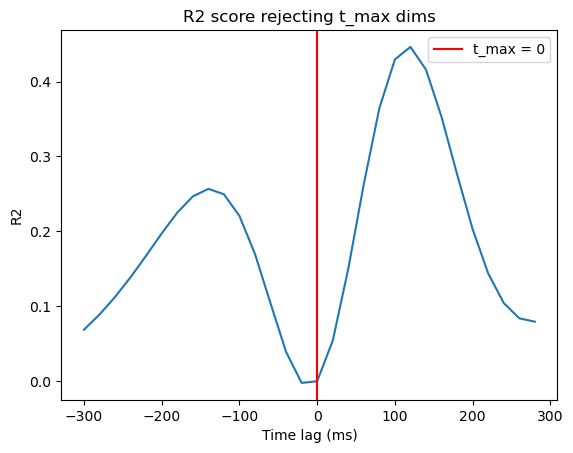

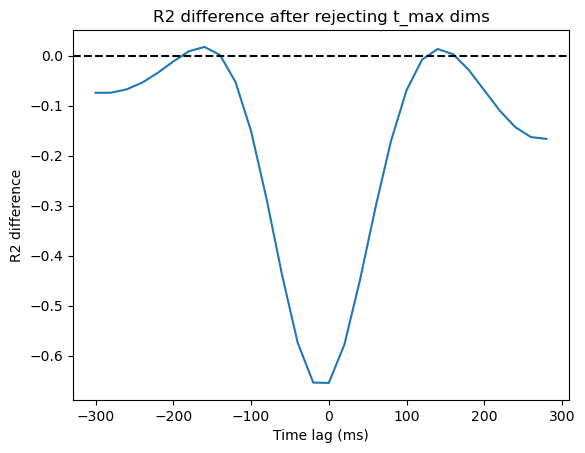

In [13]:
PCA_whole_r2_array = []
PCA_whole_coef_array = []
for lag in lag_axis:
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    PCA_whole_r2_array.append(r2)
    PCA_whole_coef_array.append(coef)

curr_r2_array = np.array(PCA_whole_r2_array)
curr_coef_array = np.array(PCA_whole_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.14632472426895937
R2: -0.10640176206767782
R2: -0.06019654979636657
R2: -0.03639492347362139
R2: -0.039041051011547756
R2: -0.06101153040542595
R2: -0.09338956115403141
R2: -0.1181576659787873
R2: -0.09465169654266425
R2: 0.013229039536240439
R2: 0.19280511192411498
R2: 0.3843752466579836
R2: 0.5447025374127481
R2: 0.6598945968482746
R2: 0.7177941407442242
R2: 0.7220391768825609
R2: 0.7070995162619319
R2: 0.7077792174724266
R2: 0.7232843833327227
R2: 0.734291235284797
R2: 0.7316329391724179
R2: 0.7165689967888985
R2: 0.69971912504514
R2: 0.6887419287869714
R2: 0.6793591500629562
R2: 0.6680551220484191
R2: 0.65474402032711
R2: 0.6373728431689638
R2: 0.6116244521969461
R2: 0.5772108386579471


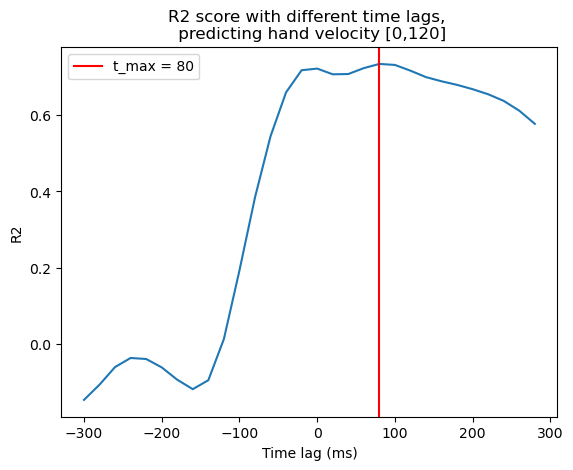

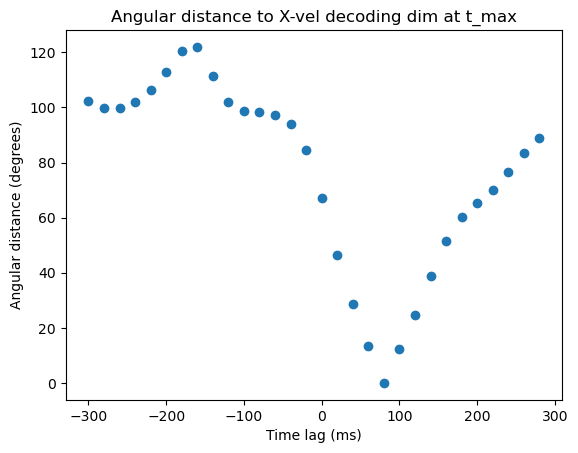

R2: 0.06113280787384179
R2: 0.07426388245578874
R2: 0.08700197907979235
R2: 0.089430769741906
R2: 0.08009716021228974
R2: 0.06680370537726465
R2: 0.05672860852597372
R2: 0.05394494970393393
R2: 0.0756693784095237
R2: 0.15426727169429844
R2: 0.2967624214649933
R2: 0.4528789058835525
R2: 0.5904198789110122
R2: 0.692035322709691
R2: 0.7358303406008295
R2: 0.7042284503886694
R2: 0.5886007048787547
R2: 0.39845003342924845
R2: 0.17761472950353474
R2: -0.003542451611661779
R2: -0.07432620953106261
R2: -0.0024846546855616936
R2: 0.17499127269273385
R2: 0.3675690126192557
R2: 0.4998088396762419
R2: 0.570859750731952
R2: 0.6197481465267185
R2: 0.6533794100067243
R2: 0.6545652378017033
R2: 0.6291745457929228


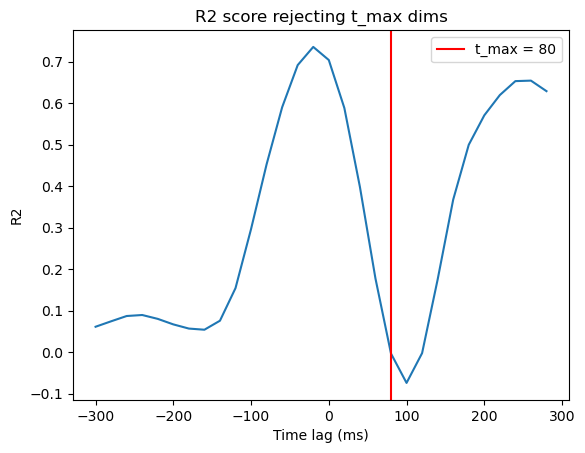

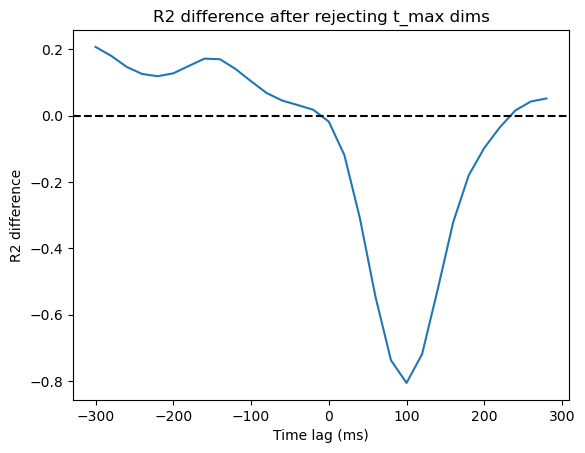

In [14]:
PCA_early_r2_array = []
PCA_early_coef_array = []
for lag in lag_axis:    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    PCA_early_r2_array.append(r2)
    PCA_early_coef_array.append(coef)

curr_r2_array = np.array(PCA_early_r2_array)
curr_coef_array = np.array(PCA_early_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



# Multi Lags

In [47]:
dataset_50ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_50ms.resample(50)
print(dataset_50ms.bin_width)

50


In [48]:
n_dims = 20 # for PCA

active_mask = (~dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')
passive_mask = (dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_50ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_50ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

171 trials
65 neurons
(44469, 65)
(44465, 65)
(44469, 20)
PCA total var explained: 0.4018730163482531


In [49]:
passive_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-300, 700), ignored_trials=~trial_mask)
for idx, trial in passive_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

passive_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
passive_trials_vel = nans([n_trials,n_timepoints,2])
passive_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in passive_data.groupby('trial_id'):
    passive_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    passive_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    passive_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(passive_trials_neuron.shape)
print(passive_trials_vel.shape)
print(passive_trials_pca.shape)


20 time bins
(171, 20, 65)
(171, 20, 2)
(171, 20, 20)


## with Neurons

In [50]:
data_range = [-300,700]
pred_start = 0
pred_end = 120

idx1 = int((pred_start - data_range[0])/dataset_50ms.bin_width)
idx2 = int(n_timepoints - (data_range[1]-pred_end)/dataset_50ms.bin_width)

t_before_range = range(0,201,50);
t_after_range = range(0,201,50);

whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_neurons])
        i = 0
        for trial_data in passive_trials_neuron:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = passive_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in kf.split(range(0,n_trials)):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.6789782267429916
Predicting with 0 to 50 ms neural data
R2: 0.7383718563427237
Predicting with 0 to 100 ms neural data
R2: 0.7908687225259099
Predicting with 0 to 150 ms neural data
R2: 0.7955331881664417
Predicting with 0 to 200 ms neural data
R2: 0.8146530896102506
Predicting with -50 to 0 ms neural data
R2: 0.7517817483299201
Predicting with -50 to 50 ms neural data
R2: 0.7906921887250712
Predicting with -50 to 100 ms neural data
R2: 0.832641791667762
Predicting with -50 to 150 ms neural data
R2: 0.8294560001521191
Predicting with -50 to 200 ms neural data
R2: 0.8426961851972019
Predicting with -100 to 0 ms neural data
R2: 0.728331749952875
Predicting with -100 to 50 ms neural data
R2: 0.791639247968483
Predicting with -100 to 100 ms neural data
R2: 0.8293145410673785
Predicting with -100 to 150 ms neural data
R2: 0.8336156877216376
Predicting with -100 to 200 ms neural data
R2: 0.8475109379590163
Predicting with -150 to 0 ms neural data
R

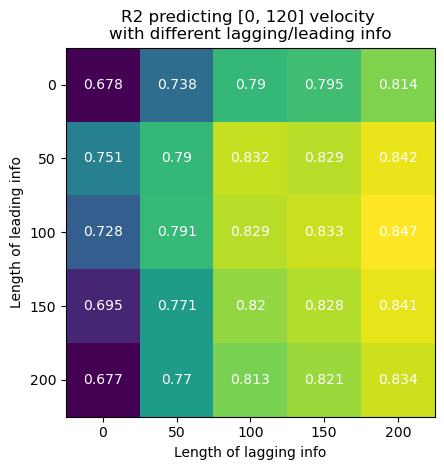

In [51]:
fig, ax = plt.subplots()
im = ax.imshow(whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()
 
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

## with PCA

In [53]:
PCA_whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
PCA_whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_dims])
        i = 0
        for trial_data in passive_trials_pca:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = passive_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        kf =KFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in kf.split(range(0,n_trials)):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        PCA_whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',PCA_whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    PCA_whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5584253244504616
Predicting with 0 to 50 ms neural data
R2: 0.6838334564931499
Predicting with 0 to 100 ms neural data
R2: 0.7570791222680493
Predicting with 0 to 150 ms neural data
R2: 0.7653454296893967
Predicting with 0 to 200 ms neural data
R2: 0.77879501964412
Predicting with -50 to 0 ms neural data
R2: 0.6970376504192548
Predicting with -50 to 50 ms neural data
R2: 0.7646267135406438
Predicting with -50 to 100 ms neural data
R2: 0.8099515619308107
Predicting with -50 to 150 ms neural data
R2: 0.8100052223235323
Predicting with -50 to 200 ms neural data
R2: 0.8168825113325349
Predicting with -100 to 0 ms neural data
R2: 0.7133366509885272
Predicting with -100 to 50 ms neural data
R2: 0.7723526247869776
Predicting with -100 to 100 ms neural data
R2: 0.814932754691689
Predicting with -100 to 150 ms neural data
R2: 0.8177525126249499
Predicting with -100 to 200 ms neural data
R2: 0.8227757049013592
Predicting with -150 to 0 ms neural data
R

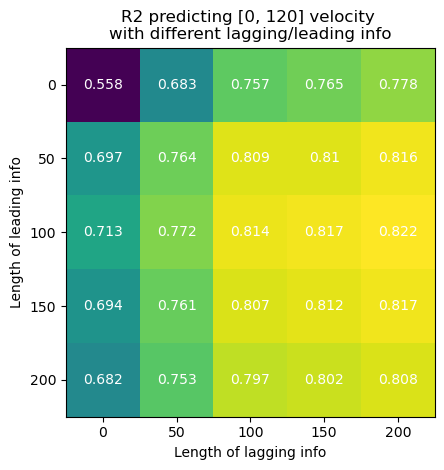

In [54]:
fig, ax = plt.subplots()
im = ax.imshow(PCA_whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(PCA_whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()